### Distance-based comparison

In [38]:
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.stats import skew, kurtosis, norm, expon, gamma
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist
from scipy.spatial import cKDTree

from shapely.geometry import Point, Polygon

from astropy.stats import RipleysKEstimator

from scipy.spatial import distance_matrix
from statsmodels.distributions.empirical_distribution import ECDF


import random
from shapely.geometry import Point
from descartes.patch import PolygonPatch

# Font
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DeJavu Serif']


In [29]:
florida_df = pd.read_csv("dataset/geocoded.csv")
florida_df.drop(['Unnamed: 0'], axis=1, inplace=True)
# Reproject and make it gdf
geometry = [Point(lon, lat) for lon, lat in zip(florida_df['longitude'], florida_df['latitude'])]
gdf = gpd.GeoDataFrame(florida_df, geometry=geometry, crs='EPSG:4326')
proj_crs = 'EPSG:3086'
gdf = gdf.to_crs(proj_crs)

In [30]:
# Load Florida state borded
gpkg_file = "dataset/florida_borded_simplified.gpkg"
gdf_state = gpd.read_file(gpkg_file, layer='boundary')

## K-Ripley's

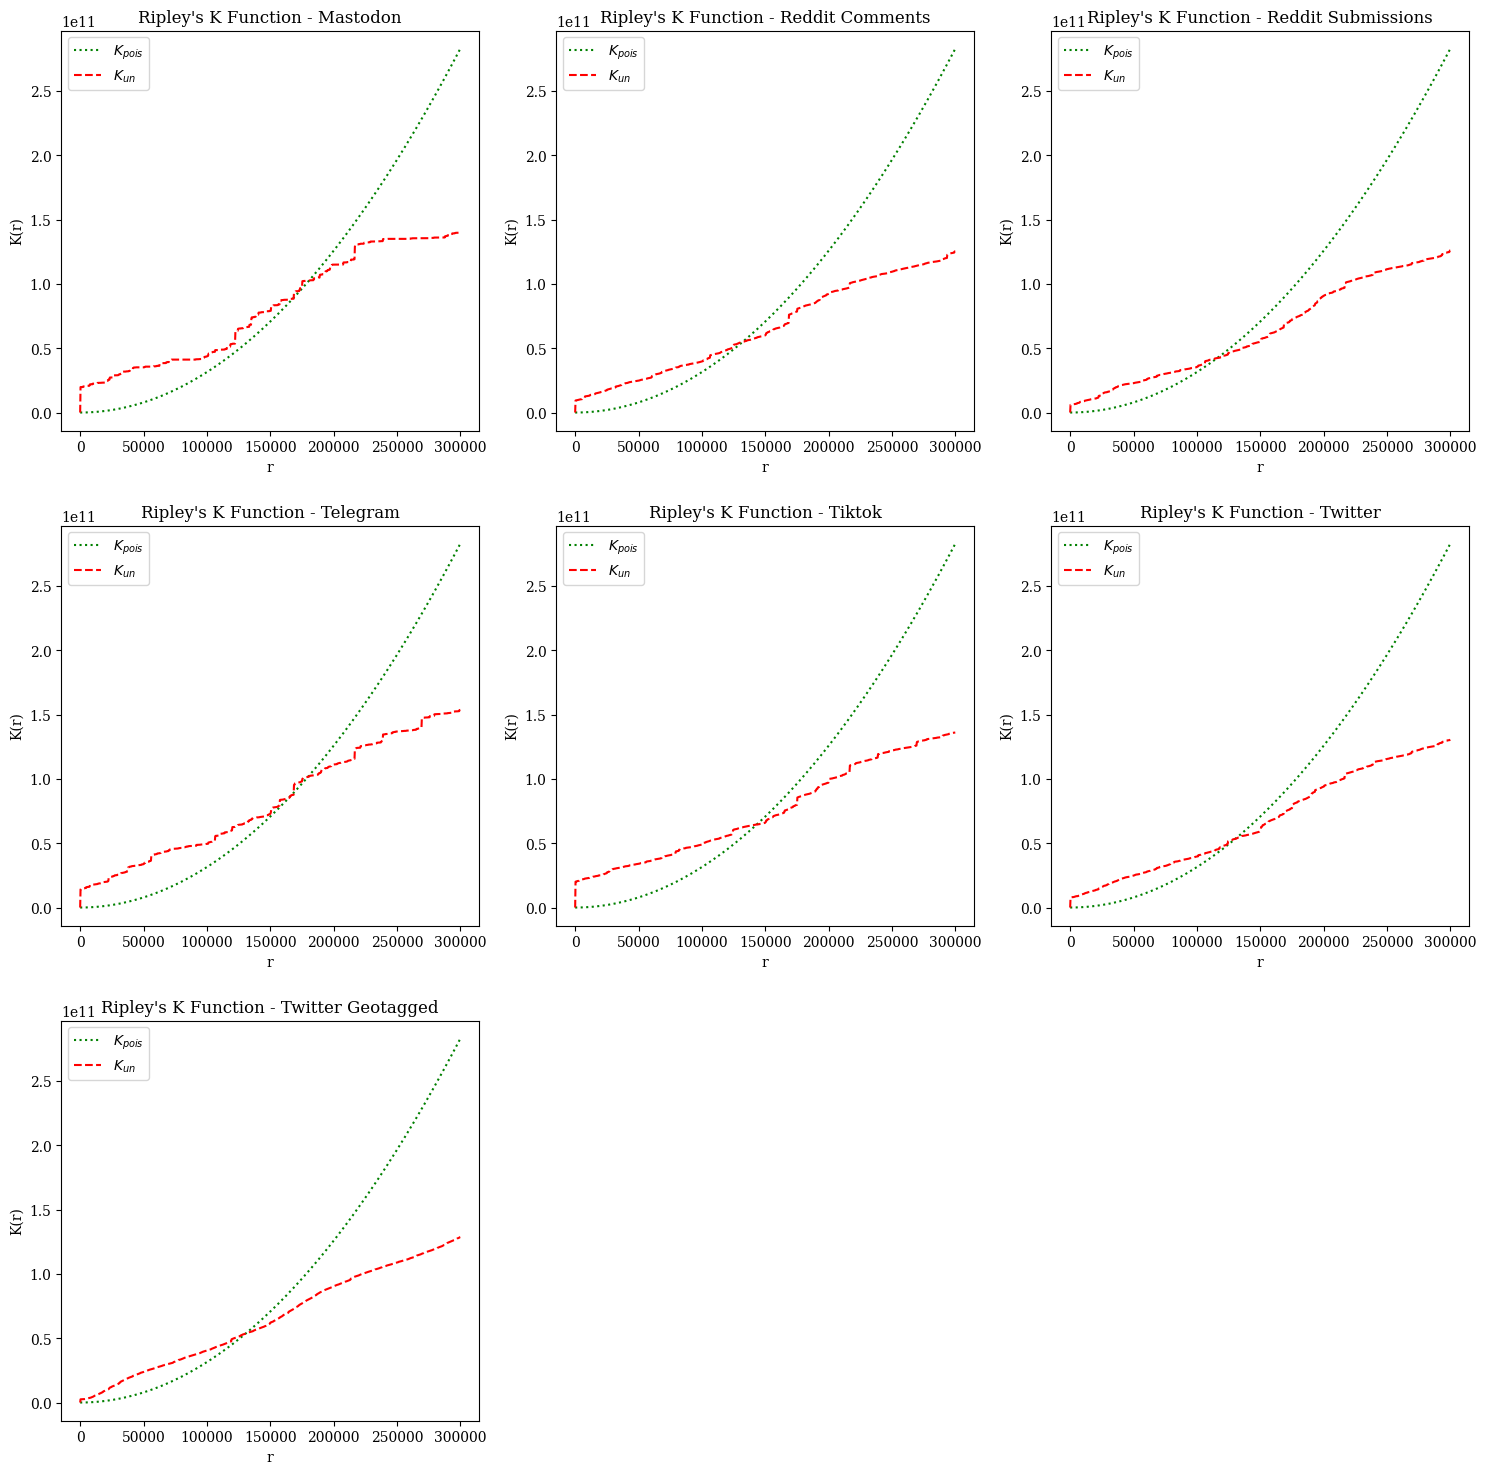

In [30]:

# Group data
grouped = gdf.groupby('source')

# Calculate metrics for each group
num_groups = len(grouped)
num_cols = 3
num_rows = (num_groups + num_cols - 1) // num_cols

# Create the subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# Iterate over each group and populate the subplots
for idx, (name, data) in enumerate(grouped, start=1):
    # data = data.sample(50)
    row_idx = (idx - 1) // num_cols
    col_idx = (idx - 1) % num_cols

    x = data.geometry.x.values
    y = data.geometry.y.values
    points = np.column_stack((x, y))

    # Initialize the RipleysKEstimator
    Kest = RipleysKEstimator(area=170312000000, x_max=data.geometry.total_bounds[2], y_max=data.geometry.total_bounds[3],
                            x_min=data.geometry.total_bounds[0], y_min=data.geometry.total_bounds[1])

    # Define radii
    r = np.linspace(0, 300000, 1000)

    ax = axes[row_idx, col_idx]
    ax.plot(r, Kest.poisson(r), color='green', ls=':', label=r'$K_{pois}$')
    ax.plot(r, Kest(data=points, radii=r, mode='none'), color='red', ls='--',
            label=r'$K_{un}$')
    ax.legend()
    ax.set_xlabel('r')
    ax.set_ylabel('K(r)')
    ax.set_title(f"Ripley's K Function - {name}")

# Hide any remaining empty subplots
for i in range(num_groups, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


## Pairwise CDF

use ks test or sum_of_absolute_differences to compare functions

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from statsmodels.distributions.empirical_distribution import ECDF
import seaborn as sns


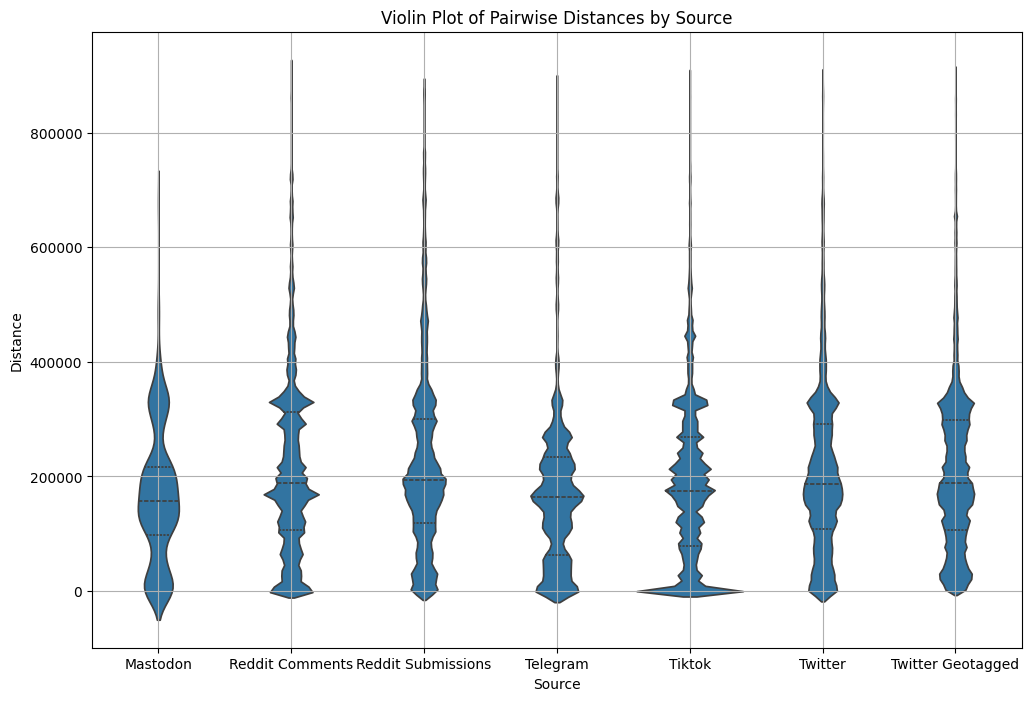

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance_matrix

grouped = gdf.groupby('source')

# Initialize lists to store distances
all_distances = []
all_labels = []

# Iterate over each group
for source, data in grouped:

    x = data.geometry.x.values
    y = data.geometry.y.values
    points = np.column_stack((x, y))

    # Pairwise distance matrix
    dist_matrix = distance_matrix(points, points)

    # Extract the upper triangle of the distance matrix without the diagonal (distance from a point to itself)
    distances = dist_matrix[np.triu_indices_from(dist_matrix, k=1)]

    # Append the distances and the corresponding source label
    all_distances.extend(distances)
    all_labels.extend([source] * len(distances))

distances_df = pd.DataFrame({'Distance': all_distances, 'Source': all_labels})

# Plot the violin plot using seaborn
plt.figure(figsize=(12, 8))
sns.violinplot(x='Source', y='Distance', data=distances_df, inner='quartile')

# Plot settings
plt.xlabel('Source')
plt.ylabel('Distance')
plt.title('Violin Plot of Pairwise Distances by Source')
plt.grid(True)
plt.show()


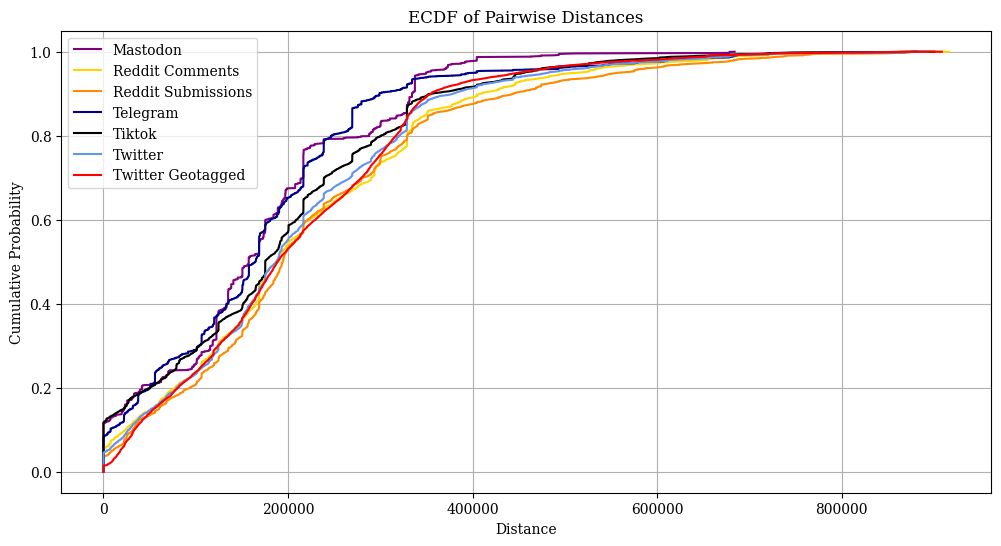

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from statsmodels.distributions.empirical_distribution import ECDF

# Group by the 'source' column
grouped = gdf.groupby('source')

# Plot the ECDF of pairwise distances as a function for each source
plt.figure(figsize=(12, 6))

for source, data in grouped:
    # Extract the x and y coordinates of the points in the current group
    x = data.geometry.x.values
    y = data.geometry.y.values
    points = np.column_stack((x, y))

    # Calculate the pairwise distance matrix
    dist_matrix = distance_matrix(points, points)

    # Extract the upper triangle of the distance matrix without the diagonal (distance from a point to itself)
    distances = dist_matrix[np.triu_indices_from(dist_matrix, k=1)]

    # Calculate the ECDF of the distances
    ecdf = ECDF(distances)
    
    color_map = {
        'Twitter': 'cornflowerblue',
        'Tiktok': 'black',
        'Reddit Submissions': 'darkorange',
        'Reddit Comments': 'gold',
        'Telegram': 'darkblue',
        'Mastodon': 'purple',
        'Twitter Geotagged': 'red',
    }
    plt.plot(ecdf.x, ecdf.y, label=source, color=color_map.get(source, 'gray'))

plt.xlabel('Distance')
plt.ylabel('Cumulative Probability')
plt.title('ECDF of Pairwise Distances')
plt.legend()
plt.grid(True)
plt.show()



# Pairwise distances KS test

In [31]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.stats import ks_2samp

grouped = gdf.groupby('source')

# Initialize lists to store KS statistics, p-values, and corresponding source pairs
ks_statistics = []
p_values = []
source_pairs = []

# Plot the CDF of pairwise distances as a function for each source
plt.figure(figsize=(12, 8))

for source1, data1 in grouped:
    for source2, data2 in grouped:
        if source1 != source2:  # Avoid comparing a source with itself and redundant pairs
            # Extract the x and y coordinates of the points in the current groups
            x1 = data1.geometry.x.values
            y1 = data1.geometry.y.values
            points1 = np.column_stack((x1, y1))

            x2 = data2.geometry.x.values
            y2 = data2.geometry.y.values
            points2 = np.column_stack((x2, y2))

            # Calculate the pairwise distance matrices
            dist_matrix1 = distance_matrix(points1, points1)
            dist_matrix2 = distance_matrix(points2, points2)

            # Extract the upper triangle of the distance matrices without the diagonal
            distances1 = dist_matrix1[np.triu_indices_from(dist_matrix1, k=1)]
            distances2 = dist_matrix2[np.triu_indices_from(dist_matrix2, k=1)]

            # Compute the KS statistic and p-value for the pair of distributions
            ks_statistic, p_value = ks_2samp(distances1, distances2)

            # Store the KS statistic, p-value, and corresponding source pairs
            ks_statistics.append(ks_statistic)
            p_values.append(p_value)
            source_pairs.append((source1, source2))

# Create a DataFrame to store the KS statistics and p-values
ks_df = pd.DataFrame({'Source 1': [pair[0] for pair in source_pairs],
                      'Source 2': [pair[1] for pair in source_pairs],
                      'KS Statistic': ks_statistics,
                      'p-value': p_values})

# Pivot the DataFrame to create a correlation matrix
correlation_matrix = ks_df.pivot(index='Source 1', columns='Source 2', values='KS Statistic')

# Display the correlation matrix
print("Correlation Matrix based on KS Statistics:")
print(correlation_matrix)

# Plot the correlation matrix as a heatmap
correlation_matrix = ks_df.pivot_table(index='Source 1', columns='Source 2', values='KS Statistic', fill_value=0)
# Replace spaces with newline character for Source 1 and Source 2
correlation_matrix.index = correlation_matrix.index.str.replace(' ', '\n')
correlation_matrix.columns = correlation_matrix.columns.str.replace(' ', '\n')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)  )
plt.title('Correlation Matrix - KS Statistics')
plt.xlabel('')
plt.ylabel('')
plt.yticks(rotation = 0)
plt.show()


Correlation Matrix based on KS Statistics:
Source 2            Mastodon  Reddit Comments  Reddit Submissions  Telegram  \
Source 1                                                                      
Mastodon                 NaN         0.175110            0.175587  0.086841   
Reddit Comments     0.175110              NaN            0.046651  0.197113   
Reddit Submissions  0.175587         0.046651                 NaN  0.185313   
Telegram            0.086841         0.197113            0.185313       NaN   
Tiktok              0.117342         0.086580            0.088108  0.113279   
Twitter             0.156314         0.047047            0.049454  0.154638   
Twitter Geotagged   0.191312         0.064257            0.057456  0.186686   

Source 2              Tiktok   Twitter  Twitter Geotagged  
Source 1                                                   
Mastodon            0.117342  0.156314           0.191312  
Reddit Comments     0.086580  0.047047           0.064257  
Reddi

<Figure size 1200x800 with 0 Axes>

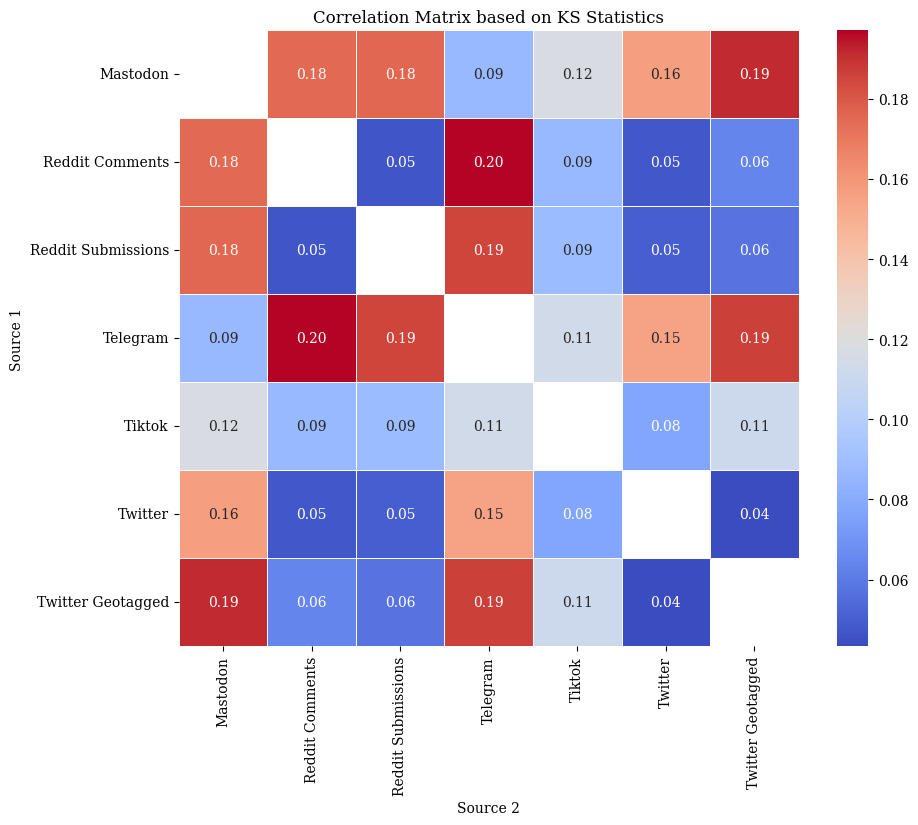

In [32]:
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix based on KS Statistics')
plt.xlabel('Source 2')
plt.ylabel('Source 1')
plt.show()

<Figure size 1200x800 with 0 Axes>

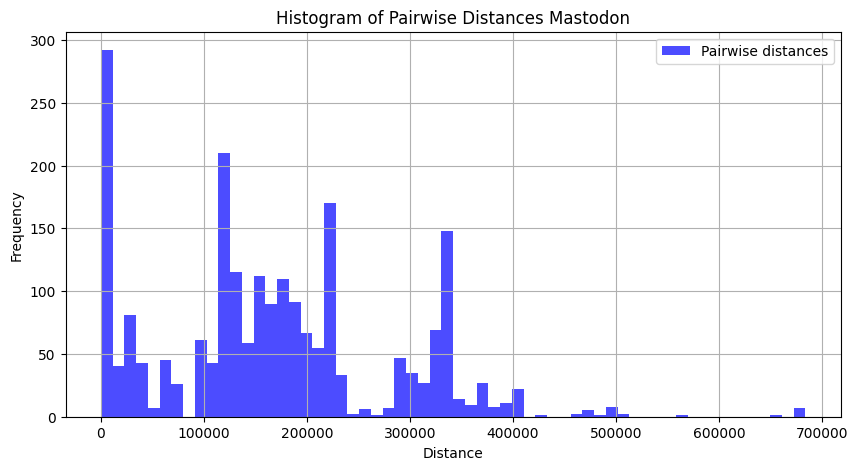

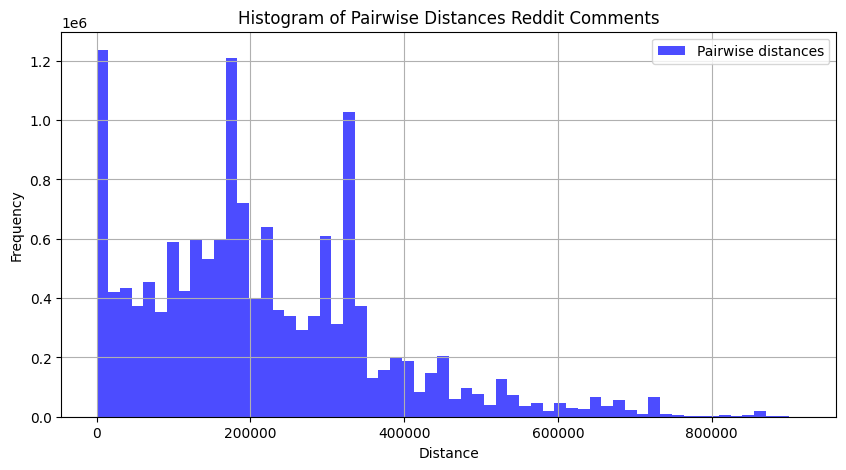

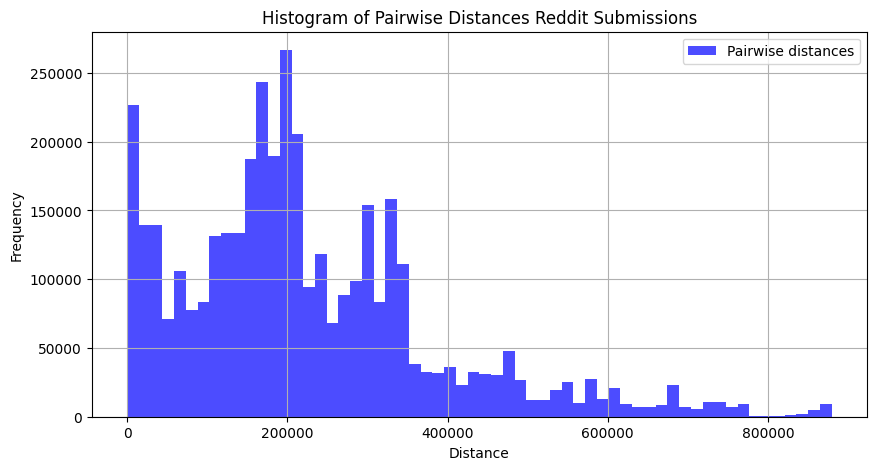

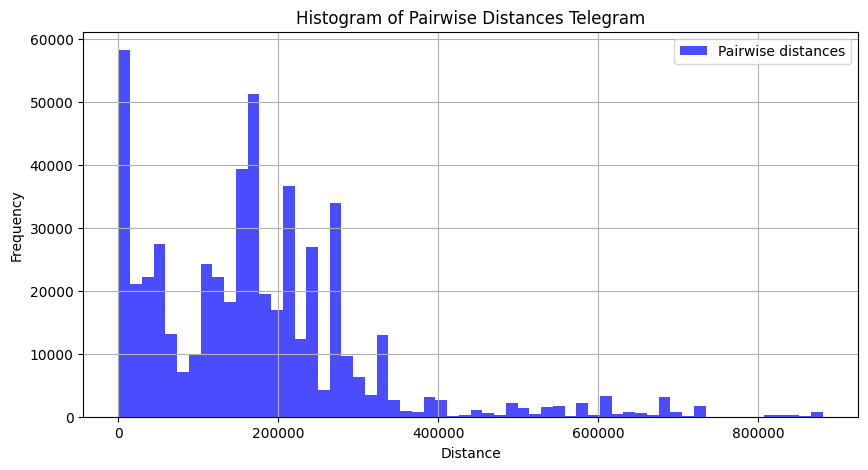

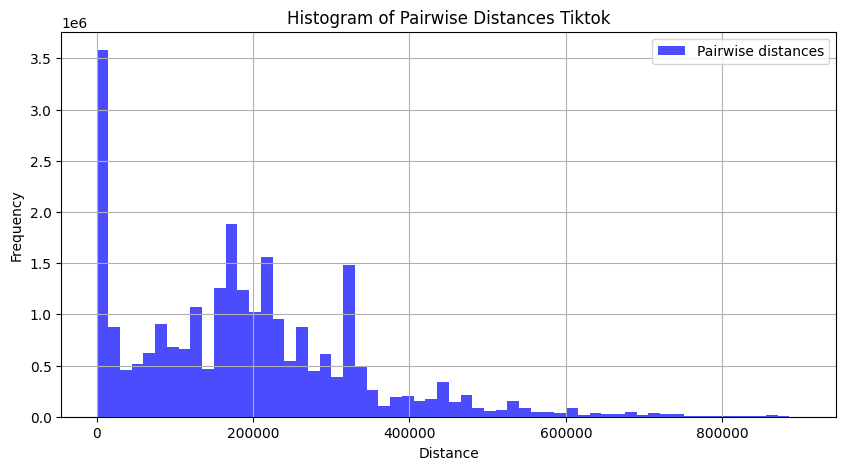

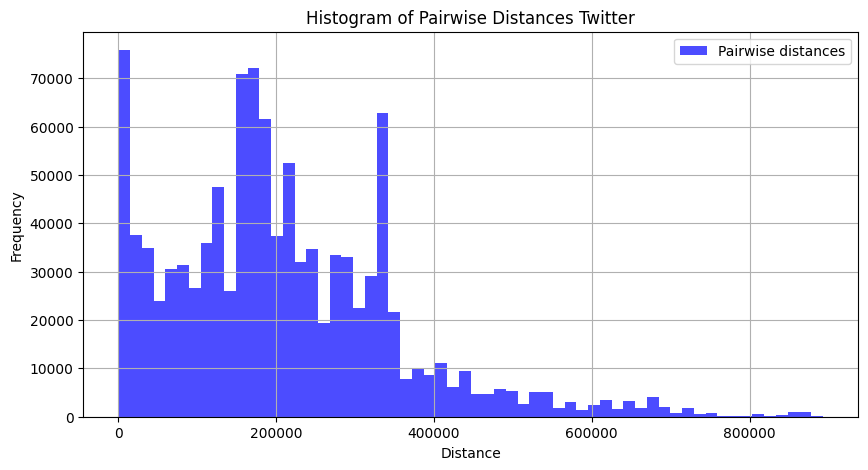

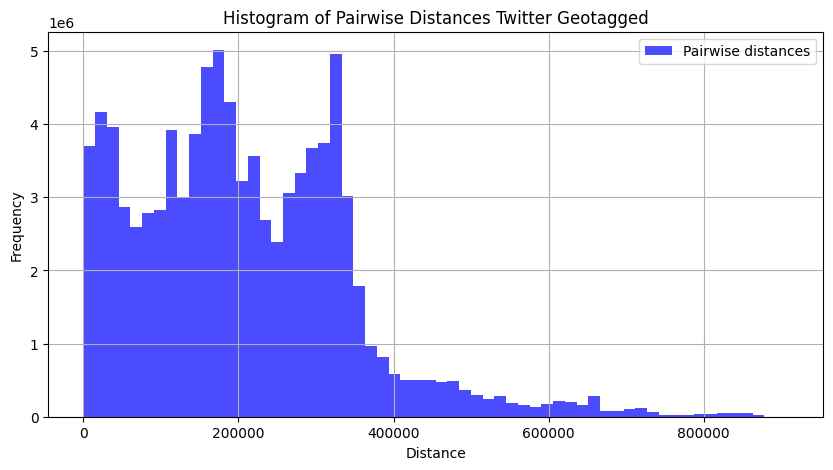

In [11]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

grouped = gdf.groupby('source')

plt.figure(figsize=(12, 8))

for source, data in grouped:
    x = data.geometry.x.values
    y = data.geometry.y.values
    points = np.column_stack((x, y))

    dist_matrix = distance_matrix(points, points)

    distances = dist_matrix[np.triu_indices_from(dist_matrix, k=1)]

    plt.figure(figsize=(10, 5))
    plt.hist(distances, bins=60, color='blue', alpha=0.7, label='Pairwise distances')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Pairwise Distances {source}')
    plt.legend()
    plt.grid(True)
    plt.show()

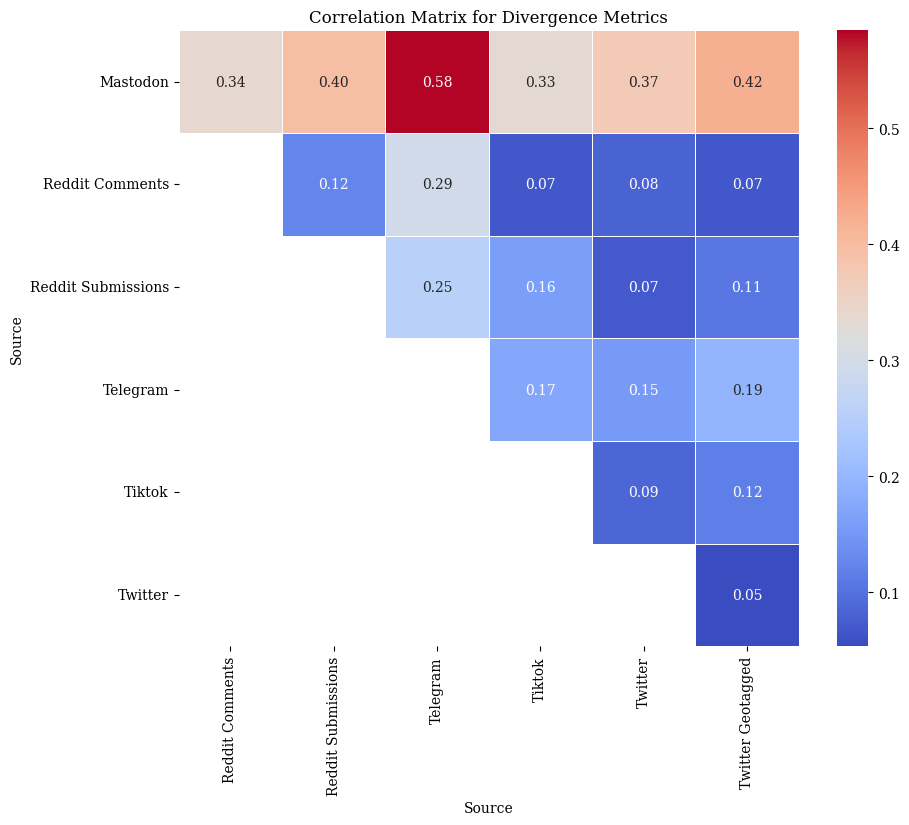

In [8]:
# Convert the divergence metrics to a DataFrame
divergence_df = pd.DataFrame(divergence_metrics, columns=['Source 1', 'Source 2', 'Divergence'])

correlation_df = divergence_df.pivot(index='Source 1', columns='Source 2', values='Divergence')

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

mask = np.triu(np.ones_like(correlation_df, dtype=bool))

sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=mask, vmin=0, vmax=1, cbar=False)

plt.title("Correlation Matrix for Divergence Metrics")
plt.xlabel("Source")
plt.ylabel("Source")
plt.show()

# Monte Carlo on NN and NNI

One done
One done
One done
One done
One done
One done
One done


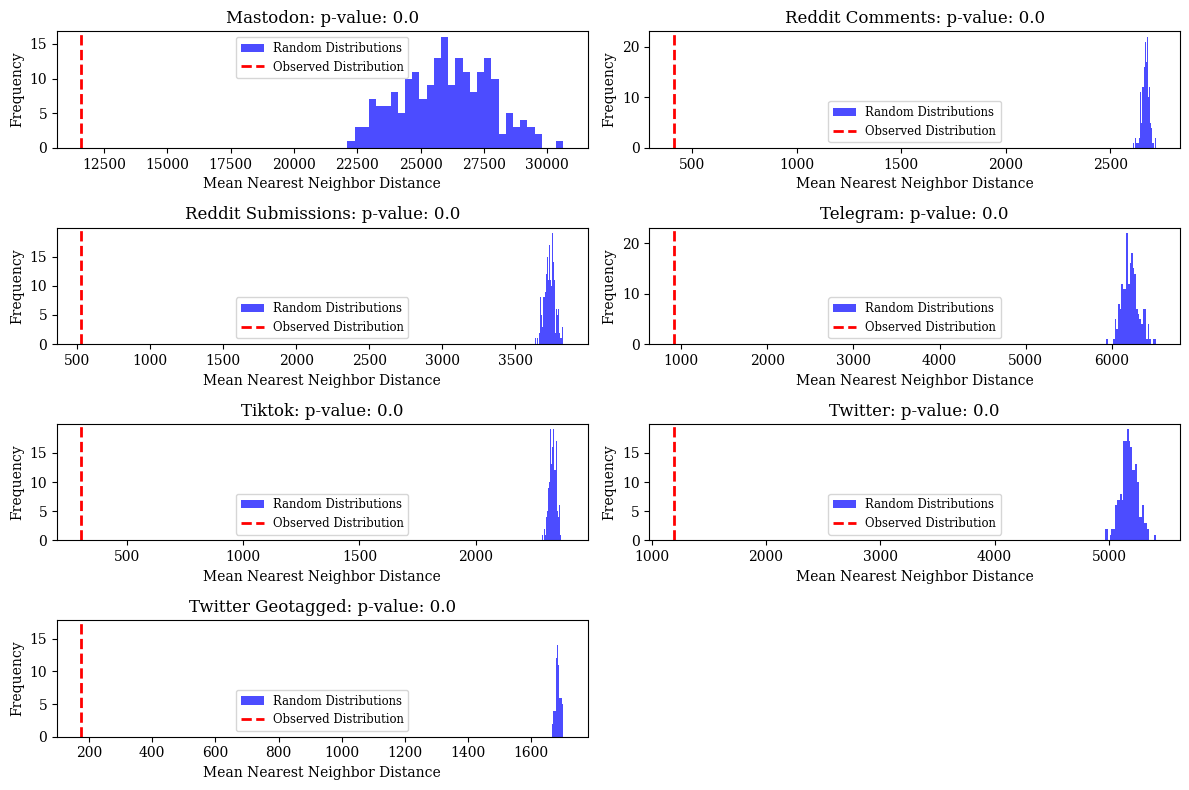

In [3]:

# Function to calculate mean nearest neighbor distance
def mean_nearest_neighbor_distance(points):
    tree = cKDTree(points)
    distances, _ = tree.query(points, k=2)
    return np.mean(distances[:, 1])

# Function to perform Monte Carlo simulation
def monte_carlo_simulation(observed_points, boundary, num_simulations=200):
    min_x, min_y, max_x, max_y = boundary.total_bounds
    observed_points_coords = np.column_stack((observed_points.geometry.x, observed_points.geometry.y))
    observed_statistic = mean_nearest_neighbor_distance(observed_points_coords)
    # print(min_x, min_y, max_x, max_y)
    random_statistics = []
    for _ in range(num_simulations):
        points = []
        # for _ in range(num_points):
        while len(points) <=len(observed_points):
            random_point = Point(random.uniform(boundary.total_bounds[0], boundary.total_bounds[2]), 
                                random.uniform(boundary.total_bounds[1], boundary.total_bounds[3]))
            if boundary.geometry.contains(random_point).any():
                points.append(random_point)
        
        random_x = []
        random_y = []
        for point in points:
            random_x.append(point.x) 
            random_y.append(point.y)
        random_points = np.column_stack((random_x, random_y))
            # Generate random points within the multipolygon(s)

        random_statistic = mean_nearest_neighbor_distance(random_points)
        random_statistics.append(random_statistic)
    
    random_statistics = np.array(random_statistics)
    p_value = np.sum(random_statistics <= observed_statistic) / num_simulations
    
    return observed_statistic, random_statistics, p_value

# Load your GeoDataFrame
gpkg_file = "dataset/florida_borded_simplified.gpkg"

gdf_state = gpd.read_file(gpkg_file, layer='boundary')

    
# Set the number of rows and columns for the subplot grid
num_rows = len(grouped) // 2 + len(grouped) % 2
num_cols = 2

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Flatten the axs array to iterate over the subplots
axs = axs.flatten()

# Iterate over the groups
for i, (source, data) in enumerate(grouped):
    ax = axs[i]
    
    # Perform Monte Carlo simulation
    observed_stat, random_stats, p_value = monte_carlo_simulation(data, gdf_state)
    print("One done")

    # Plot the results
    ax.hist(random_stats, bins=30, alpha=0.7, color='blue', label='Random Distributions')
    ax.axvline(observed_stat, color='red', linestyle='dashed', linewidth=2, label='Observed Distribution')
    ax.set_xlabel('Mean Nearest Neighbor Distance')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{source}: p-value: {p_value}')
    ax.legend(fontsize='small')

# Hide any unused subplots
for i in range(len(grouped), num_rows * num_cols):
    axs[i].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


1001


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


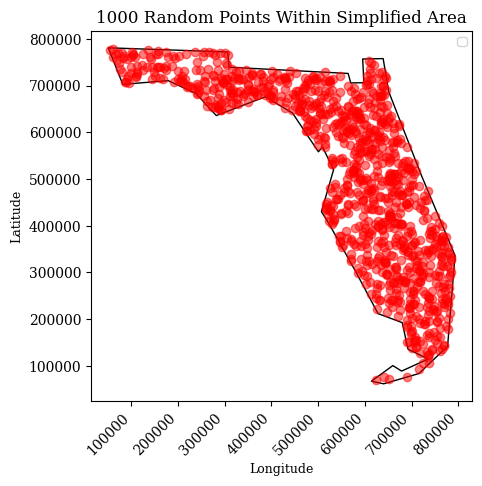

In [19]:
def plot_geodataframe_with_points(geodataframe, num_points):
    fig, ax = plt.subplots()
    
    # Plot the multipolygon(s)
    geodataframe.plot(ax=ax, edgecolor='black', facecolor='none')

    # Generate random points within the multipolygon(s)
    points = []
    # for _ in range(num_points):
    while len(points) <=1000:
        random_point = Point(random.uniform(geodataframe.total_bounds[0], geodataframe.total_bounds[2]), 
                             random.uniform(geodataframe.total_bounds[1], geodataframe.total_bounds[3]))
        if geodataframe.geometry.contains(random_point).any():
            points.append(random_point)
    print(len(points))
    # Plot the random points
    for point in points:
        ax.plot(point.x, point.y, 'ro', alpha =.5)
    
    ax.set_xlabel('Longitude',fontsize=9)
    ax.set_ylabel('Latitude', fontsize=9)   
    ax.legend(fontsize='small')  # Set font size for legend

    ax.set_aspect('equal', adjustable='box')
    plt.xlabel('Longitude')
    plt.xticks(rotation = 45, ha = "right")
    plt.ylabel('Latitude')
    plt.title('1000 Random Points Within Simplified Area')
    plt.show()

# Example usage:
gpkg_file = "dataset/florida_borded_simplified.gpkg"
polygon = gpd.read_file(gpkg_file, layer='boundary')#.geometry.iloc[0]
plot_geodataframe_with_points(polygon, 1000)


One done Mastodon
26136.178025230627
11596.166183837498
One done Reddit Comments
2672.0927805101555
410.1710274479485
One done Reddit Submissions
3739.17711677647
529.4316011958442
One done Telegram
6215.0192559164225
914.3477538911959
One done Tiktok
2330.635334554998
303.9343116603062
One done Twitter
5185.682148642631
1191.7060056813616
One done Twitter Geotagged
1684.07768350948
174.39713687849707


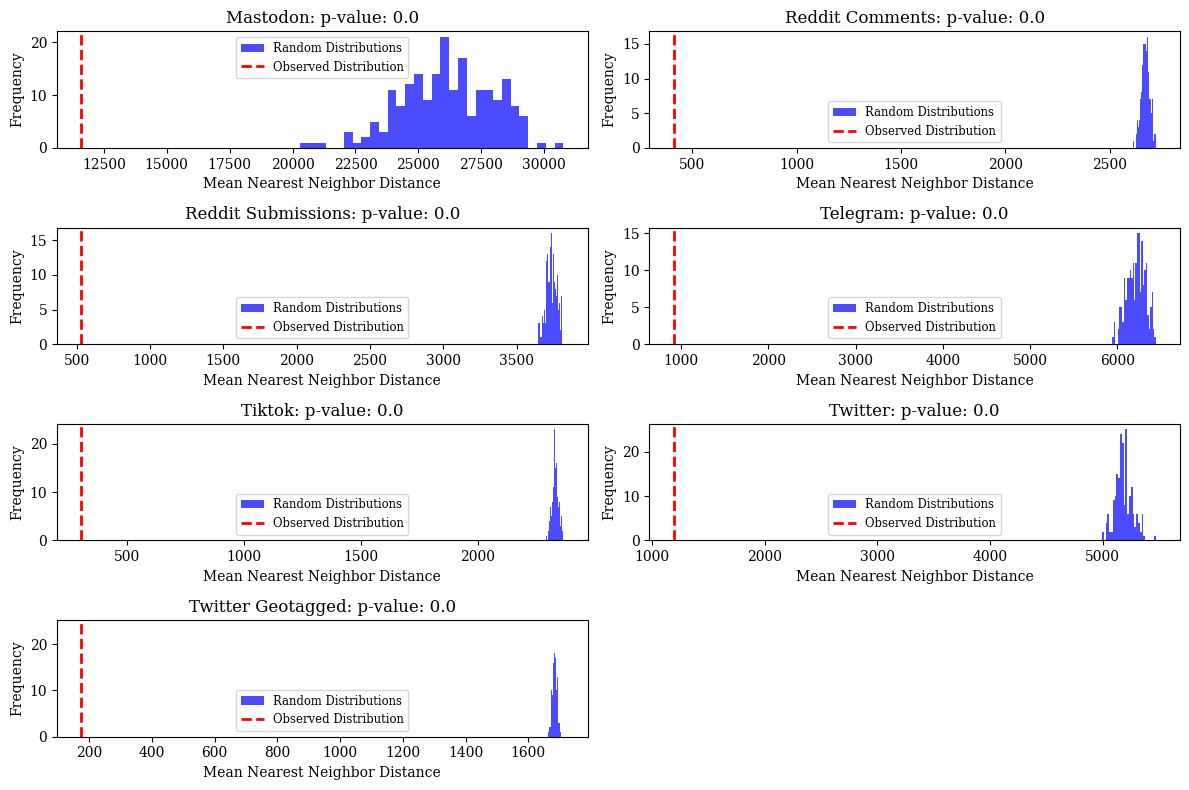

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import geopandas as gpd
import random
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopandas import GeoDataFrame
from descartes.patch import PolygonPatch

# Function to calculate mean nearest neighbor distance
def mean_nearest_neighbor_distance(points):
    tree = cKDTree(points)
    distances, _ = tree.query(points, k=2)
    return np.mean(distances[:, 1])

# Function to perform Monte Carlo simulation
def monte_carlo_simulation(observed_points, boundary, num_simulations=200):
    min_x, min_y, max_x, max_y = boundary.total_bounds
    observed_points_coords = np.column_stack((observed_points.geometry.x, observed_points.geometry.y))
    observed_statistic = mean_nearest_neighbor_distance(observed_points_coords)
    # print(min_x, min_y, max_x, max_y)
    random_statistics = []
    for _ in range(num_simulations):
        points = []
        # for _ in range(num_points):
        while len(points) <=len(observed_points):
            random_point = Point(random.uniform(boundary.total_bounds[0], boundary.total_bounds[2]), 
                                random.uniform(boundary.total_bounds[1], boundary.total_bounds[3]))
            if boundary.geometry.contains(random_point).any():
                points.append(random_point)
        

        random_x = []
        random_y = []
        for point in points:
            random_x.append(point.x) 
            random_y.append(point.y)
        random_points = np.column_stack((random_x, random_y))
            # Generate random points within the multipolygon(s)

        random_statistic = mean_nearest_neighbor_distance(random_points)
        random_statistics.append(random_statistic)
    
    random_statistics = np.array(random_statistics)
    p_value = np.sum(random_statistics <= observed_statistic) / num_simulations
    
    return observed_statistic, random_statistics, p_value

# Load your GeoDataFrame
gpkg_file = "dataset/florida_borded_simplified.gpkg"

gdf_state = gpd.read_file(gpkg_file, layer='boundary')

    
# Set the number of rows and columns for the subplot grid
num_rows = len(grouped) // 2 + len(grouped) % 2
num_cols = 2

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Flatten the axs array to iterate over the subplots
axs = axs.flatten()

# Iterate over the groups
for i, (source, data) in enumerate(grouped):
    ax = axs[i]
    
    # Perform Monte Carlo simulation
    observed_stat, random_stats, p_value = monte_carlo_simulation(data, gdf_state)
    print(f"One done {source}") 
    mean_random_statistics = np.mean(random_stats)
    print(mean_random_statistics)
    print(observed_stat)
    # Plot the results
    ax.hist(random_stats, bins=30, alpha=0.7, color='blue', label='Random Distributions')
    ax.axvline(observed_stat, color='red', linestyle='dashed', linewidth=2, label='Observed Distribution')
    ax.set_xlabel('Mean Nearest Neighbor Distance')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{source}: p-value: {p_value}')
    ax.legend(fontsize='small')

# Hide any unused subplots
for i in range(len(grouped), num_rows * num_cols):
    axs[i].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


In [10]:
import numpy as np

# Provided data
data = {
    "Mastodon": [26136.178025230627, 11596.166183837498, 67],
    "Reddit Comments": [2672.0927805101555, 410.1710274479485, 5431],
    "Reddit Submissions": [3739.17711677647, 529.4316011958442, 2795],
    "Telegram": [6215.0192559164225, 914.3477538911959, 1032],
    "Tiktok": [2330.635334554998, 303.9343116603062, 7119],  # Assuming number of points is missing
    "Twitter": [5185.682148642631, 1191.7060056813616, 1465],
    "Twitter Geotagged": [1684.07768350948, 174.39713687849707, 13531],
}

# Initialize lists for LaTeX table
platforms = []
observed_values = []
expected_values = []
nn_indices = []
z_scores = []

# Calculate NN Index and Z-scores
results = []
for platform, (expected, observed, n) in data.items():
    nn_index = observed / expected
    se = expected / np.sqrt(n)
    z_score = (observed - expected) / se

    results.append((platform, nn_index, z_score))

    # Append to lists
    platforms.append(platform)
    observed_values.append(observed)
    expected_values.append(expected)
    nn_indices.append(nn_index)
    z_scores.append(z_score)

# Print results
for platform, nn_index, z_score in results:
    print(f"{platform}: NN Index = {nn_index:.4f}, Z-score = {z_score:.4f}")

# Create LaTeX table
latex_table = """
\\begin{table}[h]
\\centering
\\begin{tabular}{|l|c|c|c|c|}
\\hline
Platform & Observed & Expected & NN Index & Z-score \\\\
\\hline
"""
for i in range(len(platforms)):
    platform = platforms[i]
    observed = observed_values[i]
    expected = expected_values[i]
    nn_index = nn_indices[i]
    z_score = z_scores[i]
    if not np.isnan(z_score):
        latex_table += f"{platform} & {observed:.2f} & {expected:.2f} & {nn_index:.4f} & {z_score:.4f} \\\\\n"
    else:
        latex_table += f"{platform} & {observed:.2f} & {expected:.2f} & {nn_index:.4f} & Not available \\\\\n"
latex_table += """
\\hline
\\end{tabular}
\\caption{Observed and Expected Nearest Neighbor Index (NNI) and Z-scores for Different Platforms}
\\end{table}
"""

# Print LaTeX table
print(latex_table)


Mastodon: NN Index = 0.4437, Z-score = -4.5537
Reddit Comments: NN Index = 0.1535, Z-score = -62.3830
Reddit Submissions: NN Index = 0.1416, Z-score = -45.3822
Telegram: NN Index = 0.1471, Z-score = -27.3986
Tiktok: NN Index = 0.1304, Z-score = -73.3711
Twitter: NN Index = 0.2298, Z-score = -29.4794
Twitter Geotagged: NN Index = 0.1036, Z-score = -104.2768

\begin{table}[h]
\centering
\begin{tabular}{|l|c|c|c|c|}
\hline
Platform & Observed & Expected & NN Index & Z-score \\
\hline
Mastodon & 11596.17 & 26136.18 & 0.4437 & -4.5537 \\
Reddit Comments & 410.17 & 2672.09 & 0.1535 & -62.3830 \\
Reddit Submissions & 529.43 & 3739.18 & 0.1416 & -45.3822 \\
Telegram & 914.35 & 6215.02 & 0.1471 & -27.3986 \\
Tiktok & 303.93 & 2330.64 & 0.1304 & -73.3711 \\
Twitter & 1191.71 & 5185.68 & 0.2298 & -29.4794 \\
Twitter Geotagged & 174.40 & 1684.08 & 0.1036 & -104.2768 \\

\hline
\end{tabular}
\caption{Observed and Expected Nearest Neighbor Index (NNI) and Z-scores for Different Platforms}
\end{table